# things to try
1. 적분값(Sum), peak number => labeling(완료)
2. Functional API => 복잡한 형태의 네트워크를 구현(완료)
3. multiple input, multiple ouput 형태의 네트워크 compile, fit 방법 공부(완료)
4. Lmfit 등의 library에서 overlapping graph fitting하는데 몇 개의 factor가 필요한지 알아낼 것(불필요, 시간부족)
5. 그 과정을 활용하거나 자동화하여 데이터 라벨링을 할 수 있는지 알아낼 것!

# 처음부터 다시 프로그래밍할 주제 :
* 임의의 파라미터 조합으로 스펙트럼 만들고, 추출가능한 peak 또는 curve만을 detection하는 방법 알아낼 것!(peakonly, minimize, curve-fitting)

# 추가 고찰
1. 실제 XPS 데이터를 peak fitting할 경우, mean position이 동일한 여러 그래프로 분해할 일은 거의 없어보인다.=> 하나의 관측가능한 피크위치에 하나의 함수를 대응시켜 피팅하는게 상식적.
2. 로렌치안 함수의 intensity를 HWHM의 함수로 고려하지 않고 독립적인 상수로 놓을 수 있다(적용 완료)

# 결론
1. 단일입력(graph) - 3중출력(area, peak_number, parameters) 데이터셋 생성
2. 피크가 겹치지 않도록 하는 제한조건은 약하게 했음(겹치는 정도는 0과 1사이)
3. Functional API로 단일입력- 3중출력 구조 만듬
4. 다중데이터 출력에 대한 학습 문법 알아내어 적용 완료
5. 다중데이터 출력에 대한 hist.loss 구조 파악 완료
6. area는 제법 잘 파악하지만, peak_number는 종종 실수가 보인다.
7. 눈에 보이는 그래프의 관측가능한 peak와 실제 peak 간의 괴리로 학습을 못하는 것 같다.

# 13번 사본과 비교한 새로운 시도:
1. 생성된 데이터에서 노이즈를 제거하고 시도해본다.(잘 된다면 denoising autoencoder를 끼워넣기 가능)
2. peak들이 서로 겹치지 않도록, 좀 더 강한 제한조건으로 데이터 재생성하여 다시 시도해본다.
3. convolution층은 최소 3개로 한다! - 다른 논문들에서 대부분 3개의 컨볼루션층을 적용함


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive


In [ ]:
cd My Drive

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive


In [ ]:
ls

'[빅데이터 융합보안] 과정'/   Data_x
'1. Backup Files'/            Data_y
'[2020] 딥러닝 프로젝트'/     Data_z
'C언어 코딩도장'/            'Peak Detection and Curve-Fitting'/
 Classroom/                   shared_input_layer.png
'Colab Notebooks'/            Untitled0.ipynb


In [ ]:
# ========== Library import ==========
import numpy as np
import random
import matplotlib.pyplot as plt
import inspect


# ========== Parameter Maxtrix generation ==========
N = 5  # Maximum number of possible peak
Data_size = 100000 

Parameters = np.zeros((Data_size, N, 3))  # Set of Parameters ready
print(Parameters.shape[1])

5


In [ ]:
import numpy as np
from scipy.optimize import curve_fit, minimize

# scipy curve_fit 이용해보기.

In [ ]:
def linear(x, a, b):
    return a * x + b

x = np.linspace(0, 10, 100)
y = linear(x, 1, 2)

np.random.seed(1)
yn = y + 0.9 * np.random.normal(size=len(x))

popt, pcov = curve_fit(linear, x, yn)
print(popt)
print(pcov)

[1.02977602 1.90564447]
[[ 0.00075267 -0.00376335]
 [-0.00376335  0.02521572]]


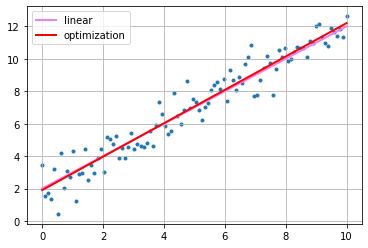

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x, yn, marker='.')
plt.plot(x, y, linewidth=2, color='violet', label='linear')
plt.plot(x, linear(x, *popt), color='red', linewidth=2, label='optimization')
plt.legend()
plt.grid('on')
plt.show()

In [ ]:
def func(x, a, b, c):
    return a * np.exp(-(x-b)**2 / (2*c**2))

x = np.linspace(0, 10, 100)
y = func(x, 1, 5, 2)
yn = y + 0.2 * np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, yn)

print(popt)
print(pcov)

[ 1.01217827  5.06673512 -2.09600457]
[[ 1.47830098e-03 -4.82758590e-06  2.10848544e-03]
 [-4.82758590e-06  8.41752522e-03 -2.45892705e-05]
 [ 2.10848544e-03 -2.45892705e-05  8.80501302e-03]]


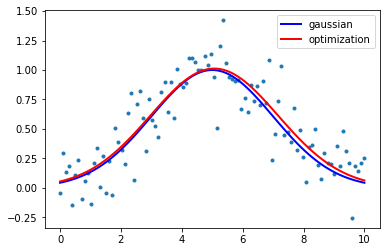

In [ ]:
plt.scatter(x, yn, marker='.')
plt.plot(x, y, linewidth = 2, color='blue', label='gaussian')
plt.plot(x, func(x, *popt), color='red', linewidth=2, label='optimization')
plt.legend()
plt.show()

In [ ]:
def func(x, b0, b1):
    a0 = 5*np.random.rand()
    a1 = 5*np.random.rand()
    c0 = 5*np.random.rand()
    c1 = 5*np.random.rand()

    return a0 * np.exp(-(x-b0)**2 / (2*c0**2)) + a1 * np.exp(-(x-b1)**2 / (2*c1**2))

x = np.linspace(0, 20, 500)
y = func(x,3,15)
yn = y + 0.2 * np.random.normal(size=len(x))

initial_guess = [3, 15]  # 이 부분에서 초기 추정치를 잘 잡아주는게 포인트!, 
guess = [4, 15]
popt, pcov = curve_fit(func, x, y, p0=initial_guess)

print(popt)
print(pcov)

[ 3. 15.]
[[ 1.42662333e-18 -3.21137877e-18]
 [-3.21137877e-18  1.13627748e-17]]


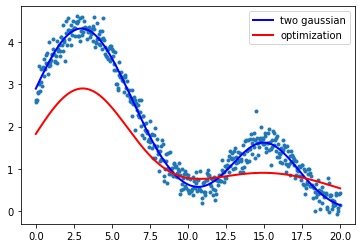

In [ ]:
plt.scatter(x, yn, marker='.')
plt.plot(x, y, linewidth=2, color='blue', label='two gaussian')
plt.plot(x, func(x, *popt), color='red', linewidth=2, label='optimization')
plt.legend()
plt.show()

In [ ]:
# 1차원 배열(그래프 y값) 입력되면, 그것의 peak 위치, 함수값 추정하는 함수 정의
def extract_params(x, array1D):

    # 노이즈가 없다고 가정하면, 그래프는 매끈한 언덕형이다.
    # 미분의 불완전한 형태인 차분 = delta_y / delta_x 구현한다.
    # 그런데 delta_x는 그냥 1로 고정시켜두면, delta_y = y[i] - y[i-1]만 계산하면 된다!
    local_maxima_y = []
    local_maxima_x = []

    N = len(array1D)
    threshold = 0.2

    for i in range(1, N):
        delta = array1D[i] - array1D[i-1] / x[i] - x[i-1] # i번째 차분값을 계산
        if abs(delta) < threshold:  # 차분값이 특정기준보다 낮아서 0으로 취급가능하다면
            local_maxima_y.append(array1D[i]) 
            local_maxima_x.append(x[i])  # 이게 진정한 극대값 x좌표!
             # i번째 차분값을 만들어내는 i번째 원함수의 값을 로컬맥시마에 저장
            # 그럼 이에 대응되는 x-domain의 i번째 값인 x[i]가 극대점에 해당할 것이라 유추가능함
    local_maxima_x = np.array(local_maxima_x)
    local_maxima_y = np.array(local_maxima_y)
    
    return local_maxima_x, local_maxima_y


In [ ]:
import numpy as np

def Lorentzian(x, *args):
    '''returns sum of Multi-Lorentzian functions
    corresponding to each three parameters (amplitude, mean, width)'''
    # in physics
    amplitude = args[::3]
    mean = args[1::3]
    width = args[2::3]
    result = 0
    for i in range(len(mean)):
        result += amplitude[i] * ( width[i]**2 / (  (x - mean[i])**2 + width[i]**2  ))

    # 이번에는 노이즈 제거해본다.
    #for xx in range(len(result)):
     #   result[xx] += 0.1 * ((np.random.rand()*2) - 1) 
        # -0.1 ~ 0.1 noise
    return result



In [ ]:
x = np.linspace(2, 7, 300)
#y = Lorentzian(x, 2, 5, 0.1, 1, 2, 0.11, 2.1, 7.5, 0.12)

def sin(x):
    return np.sin(x)

y = sin(x)


import matplotlib.pyplot as plt

maxima_x, maxima_y = extract_params(x, y)

print(maxima_x)
print(maxima_y)


[]
[]


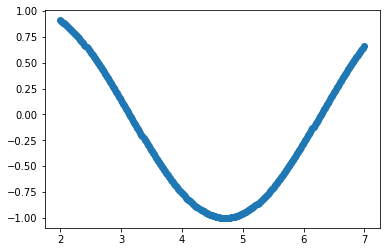

In [ ]:
plt.scatter(x, y)
plt.scatter(maxima_x, maxima_y, color='red')

# 원래 하던대로 다시 진행

In [ ]:
# ========== Definition of Lorentzian function ==========

def Lorentzian(x, *args):
    '''returns sum of Multi-Lorentzian functions
    corresponding to each three parameters (amplitude, mean, width)'''

    # in physics
    amplitude = args[::3]
    mean = args[1::3]
    width = args[2::3]

    result = 0
    for i in range(len(mean)):
        result += amplitude[i] * ( width[i]**2 / (  (x - mean[i])**2 + width[i]**2  ))

    # 이번에는 노이즈 제거해본다.
    #for xx in range(len(result)):
     #   result[xx] += 0.1 * ((np.random.rand()*2) - 1) 
        # -0.1 ~ 0.1 noise

    return result

In [ ]:
# ========== X-domain range ==========
x = np.arange(-5, 10, 0.01)
print(len(x))

1500


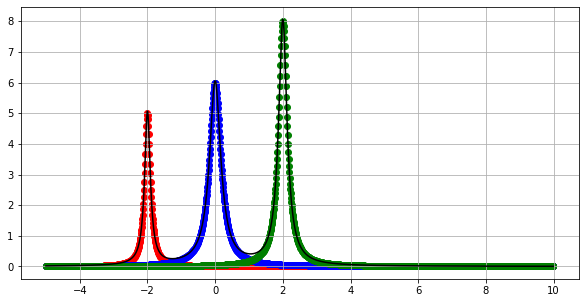

In [ ]:
# ========== Checking out of the Lorentzian function ==========
params = [5,-2,0.1, 6,0,0.2, 8, 2, 0.15]
plt.figure(figsize=(10, 5))
plt.plot(x, Lorentzian(x, *params), color = 'black')

plt.scatter(x, Lorentzian(x, *params[:3]), color = 'red')
plt.scatter(x, Lorentzian(x, *params[3:6]), color = 'blue')
plt.scatter(x, Lorentzian(x, *params[6::]), color = 'green')

plt.grid(True)
plt.show()


# 데이터 생성

In [ ]:
# ========== Generation of Lorentzian Parameters with Matrix Form ==========

for i in range(len(Parameters)): # For each matrix in Parameter set...

    for j in range(Parameters.shape[1]): # For each raw in each matrix...
        
        # append three argument that will be used in Lorentzian function
        # amplitude = 1 ~ 5 사이의 실수
        # Center domain = 2 ~ 10
        # width = 0.1 ~ 0.2 실수
        a = np.random.rand()     
        b = a + np.random.rand() # 두번째 피크 : 첫번째 피크 위치 + 0과 1사이
        c = b + np.random.rand()
        d = c + np.random.rand()
        e = d + np.random.rand()

        Parameters[i][0] = np.array([[ 3*np.random.rand()+1, a, 0.1*np.random.rand()+0.1]])
        Parameters[i][1] = np.array([[ 3*np.random.rand()+1, b, 0.1*np.random.rand()+0.1]])
        Parameters[i][2] = np.array([[ 3*np.random.rand()+1, c, 0.1*np.random.rand()+0.1]])
        Parameters[i][3] = np.array([[ 3*np.random.rand()+1, d, 0.1*np.random.rand()+0.1]])
        Parameters[i][4] = np.array([[ 3*np.random.rand()+1, e, 0.1*np.random.rand()+0.1]])
    
# Check out
print(Parameters)

[[[1.81919848 0.1217405  0.11229576]
  [3.91927029 0.92042009 0.11177571]
  [1.91861322 1.42085574 0.19301013]
  [3.55084723 1.96709631 0.18771856]
  [3.54909343 2.17833202 0.10654207]]

 [[2.31789912 0.56725224 0.13622003]
  [3.16942377 0.66055487 0.1757415 ]
  [3.84707676 0.71496312 0.1821705 ]
  [1.2173751  1.33714026 0.15374658]
  [3.92176037 1.60264308 0.13348983]]

 [[3.06239768 0.69241981 0.15520281]
  [3.2737765  1.56896398 0.18777855]
  [3.56531562 2.19759322 0.13638224]
  [1.46568627 2.90941508 0.14948195]
  [3.39458625 3.12533978 0.17190405]]

 ...

 [[1.11388388 0.67092612 0.13095496]
  [3.2359158  1.59886679 0.14942392]
  [1.72419325 2.0740611  0.18449905]
  [2.06719034 2.82529544 0.13307101]
  [3.45867242 3.74230846 0.11805322]]

 [[2.51882177 0.35234811 0.13584071]
  [2.32187016 0.97770566 0.13842915]
  [3.28129257 1.53139786 0.14593991]
  [2.04899278 2.14903993 0.14260995]
  [1.47932163 2.21964115 0.19518161]]

 [[1.13206157 0.71127568 0.14746389]
  [1.71663483 1.535535

In [ ]:
# ================== Data Generating ================
Data_x = []  # y values of the lorentzian 
Data_y = []  # area, peak number - labels 1
Data_z = []  # amp, cen, width parameters - labels 2

for j in Parameters:  # For each parameter matrix...
 
    peak = random.randint(1, N) # Random selection of Possible peak number : 1 ~ 5
    j = list(j.reshape((3*N,))) # reshape processing to put it as *args in function, Since j is matrix


    if peak == 1:
        Data_x.append(Lorentzian(x, *j[0:3*peak]))
        Data_y.append(np.array([sum(Lorentzian(x, *j[0:3*peak])), peak]))
        Data_z.append(np.array([j[0:3*peak] + j[3*peak:]]))

    elif peak == 2:
        Data_x.append(Lorentzian(x, *j[0:3*peak]))
        Data_y.append(np.array([sum(Lorentzian(x, *j[0:3*peak])), peak]))
        Data_z.append(np.array([j[0:3*peak] + j[3*peak:]]))

    elif peak == 3:
        Data_x.append(Lorentzian(x, *j[0:3*peak]))
        Data_y.append(np.array([sum(Lorentzian(x, *j[0:3*peak])), peak]))
        Data_z.append(np.array([j[0:3*peak] + j[3*peak:]]))

    elif peak == 4:
        Data_x.append(Lorentzian(x, *j[0:3*peak]))
        Data_y.append(np.array([sum(Lorentzian(x, *j[0:3*peak])), peak]))
        Data_z.append(np.array([j[0:3*peak] + j[3*peak:]]))

    elif peak == 5:
        Data_x.append(Lorentzian(x, *j[0:3*peak]))
        Data_y.append(np.array([sum(Lorentzian(x, *j[0:3*peak])), peak])) # 적분값, 피크 수
        Data_z.append(np.array([j[0:3*peak] + j[3*peak:]])) # 핵심 파라미터

In [ ]:
# conversion to numpy array
Data_x = np.array(Data_x)
Data_y = np.array(Data_y)
Data_z = np.array(Data_z)

# shape check
print(Data_x.shape)
print(Data_y.shape)
print(Data_z.shape)

Data_z = Data_z.reshape((100000, 15))
print(Data_z.shape)


(100000, 1500)
(100000, 2)
(100000, 1, 15)
(100000, 15)


In [ ]:
# ========== Dataset Save ==========
np.savetxt("Data_x1", Data_x)
np.savetxt("Data_y1", Data_y)
np.savetxt("Data_z1", Data_z)


In [ ]:
# ========= Dataset Load ==========
# ========= 미리 생성된 데이터 재사용할 경우 여기서부터 시작! ==========

Data_x = np.loadtxt("Data_x1")
Data_y = np.loadtxt("Data_y1")
Data_z = np.loadtxt("Data_z1")

print(Data_x.shape)
print(Data_y.shape)
print(Data_z.shape)

(100000, 1500)
(100000, 2)
(100000, 15)


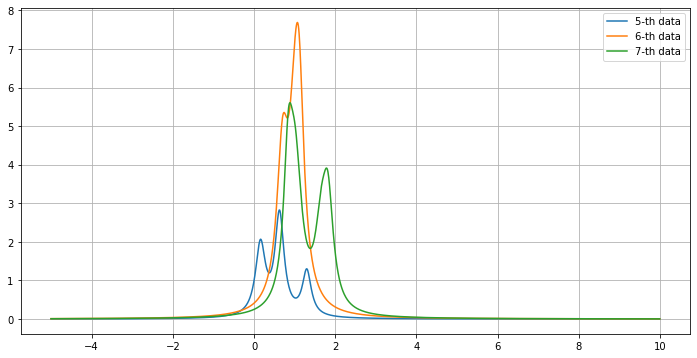

In [ ]:
# ========== Generated Data sample check! ==========

plt.figure(figsize=(12, 6))
for i in range(5, 8):
    plt.plot(x, Data_x[i], label = str(i) + '-th data')
    plt.legend()
    plt.grid('on')

In [ ]:
# ========== Data spliting up into three group : training / validation / test ==========

train_data = np.array(Data_x[:50000])
val_data   = np.array(Data_x[50000:80000])
test_data  = np.array(Data_x[80000:])


# sum, peak number - label1
sub_train_labels = np.array(Data_y[:50000])
sub_val_labels   = np.array(Data_y[50000:80000])
sub_test_labels  = np.array(Data_y[80000:])


# amp, cen, width parameters - labels2
main_train_labels = np.array(Data_z[:50000])
main_val_labels   = np.array(Data_z[50000:80000])
main_test_labels  = np.array(Data_z[80000:])

In [ ]:
# ========== size test ==========
print(train_data.shape, sub_train_labels.shape, main_train_labels.shape)
print(val_data.shape, sub_val_labels.shape, main_val_labels.shape)
print(test_data.shape, sub_test_labels.shape, main_test_labels.shape)

(50000, 1500) (50000, 2) (50000, 15)
(30000, 1500) (30000, 2) (30000, 15)
(20000, 1500) (20000, 2) (20000, 15)


In [ ]:
for i in range(5):
    print(val_labels[i:])

In [ ]:
for i in range(5):
    print(val_labels[i, 0])

In [ ]:
# reshape for Image-form setting
# 2차원일때만!
#train_data = train_data.reshape(100000, 20, 20, 1)
#val_data = val_data.reshape(150000, 20, 20, 1)
#test_data = test_data.reshape(50000, 20, 20, 1)


In [ ]:
# reshape for Image-form setting
# 1차원일때 변환
train_data = train_data.reshape(50000, len(x), 1)
val_data = val_data.reshape(30000, len(x), 1)
test_data = test_data.reshape(20000, len(x), 1)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(50000, 1500, 1)
(30000, 1500, 1)
(20000, 1500, 1)


# 2. Functional API를 활용하여 비계층적 구조 신경망 작성




Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 1401, 64)     6464        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 700, 64)      0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 700, 64)      256         max_pooling1d_8[0][0]            
____________________________________________________________________________________________

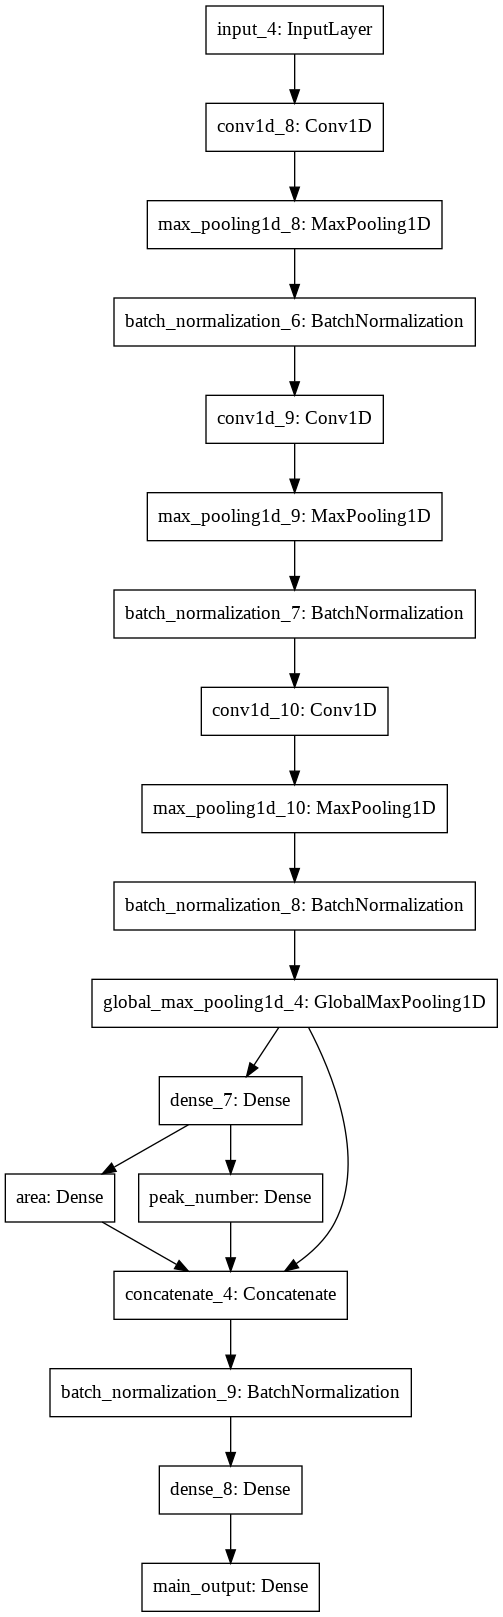

In [ ]:
# Shared Input Layer
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate

# input layer
main_inputs = Input(shape=(len(x), 1))

# At least three Convolution layer => other paper
# Adding BatchNormalization layer  => we expect the effect of regularization 
x_conv1 = Conv1D(64, kernel_size = 100, activation='relu')(main_inputs)
x_pooling1 = MaxPooling1D(pool_size=(2))(x_conv1)
x_batch1 = BatchNormalization()(x_pooling1)

x_conv2 = Conv1D(32, 50, activation='relu')(x_batch1)
x_pooling2 = MaxPooling1D(pool_size=(2))(x_conv2)
x_batch2 = BatchNormalization()(x_pooling2)

x_conv3 = Conv1D(16, 25, activation='relu')(x_batch2)
x_pooling3 = MaxPooling1D(pool_size=(2))(x_conv3)
x_batch3 = BatchNormalization()(x_pooling3)

# flat1 = Flatten()(pool1)
x_GMpooling = GlobalMaxPooling1D()(x_batch3)  # GlobalMaxPooling or GlobalAveragePooling or Flatten
x_dense = Dense(50, activation='relu')(x_GMpooling)

output_area = Dense(1, activation='linear', name='area')(x_dense)  # area
output_peak_number = Dense(1, activation='linear', name='peak_number')(x_dense)  # peak number

# merging features into one layer
merge = concatenate([output_area, output_peak_number, x_GMpooling])
merge2 = BatchNormalization()(merge)

hidden1 = Dense(50, activation='relu')(merge2)

# prediction output
main_output = Dense(15, activation='linear', name='main_output')(hidden1)

# Definition of model with one input, three output
model = Model(inputs=main_inputs, outputs=[output_area, output_peak_number, main_output])


# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_input_layer.png')

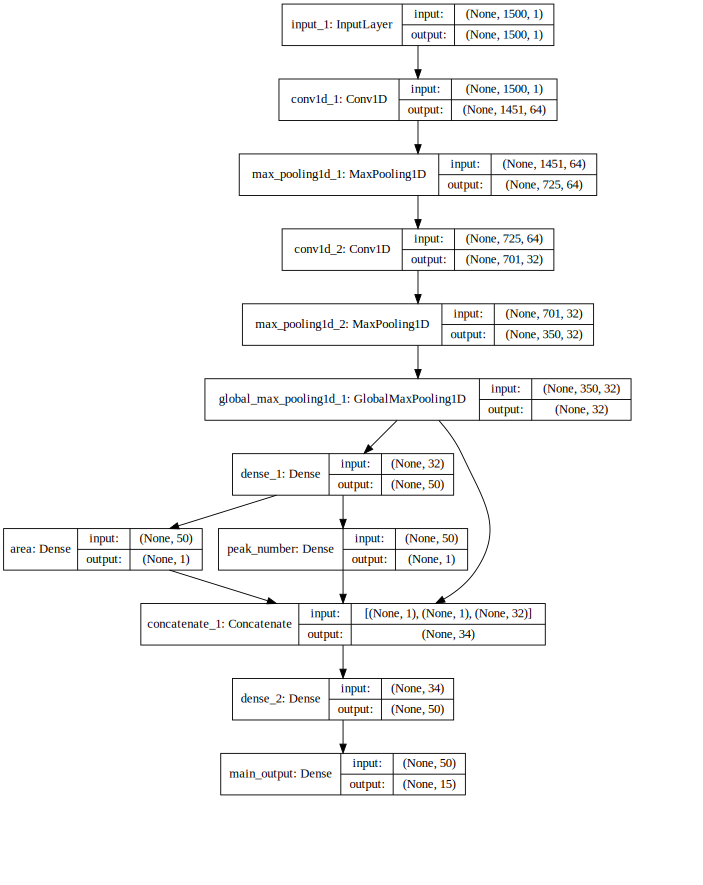

In [ ]:
# Visualization of the Neural Network architecture 

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, expand_nested = True, dpi = 65).create(prog='dot', format='svg'))

In [ ]:
# Method of the training
model.compile(loss=['mse', 'mse', 'mse'], metrics=['mae'], optimizer='adam')


In [ ]:
%%time
hist = model.fit(train_data, [train_labels[:,0], train_labels[:,1], train_labels_2], 
                   epochs=30, 
                   batch_size=2000,
                   validation_data=(val_data, [val_labels[:,0], val_labels[:,1], val_labels_2]), verbose=2)

In [ ]:
hist.history.keys()

In [ ]:
# Loss plot
plt.plot(hist.history['loss'][1:],     'b-', label="training")
plt.plot(hist.history['val_loss'][1:], 'r:', label="validation")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
test_data.shape

In [ ]:
predict = model.predict(test_data)
predict[1].shape

In [ ]:
print(predict[0].shape)
print(predict[1].shape)
print(predict[2].shape)


In [ ]:
test_label

In [ ]:
for i in range(10):
    print(predict[0][i])
    print(test_labels[i,0])
    print(predict[1][i])
    print(test_labels[i,1])
    print('===================')

    #print(predict[2][i])
    #print(test_labels_2[i])

In [ ]:
for i in range(20):
    plt.figure(figsize=(12,5))
    plt.plot(x, Lorentzian(x, *list(predict[2][i])), label=str(i)+'-th predict')
    plt.plot(x, test_data[i], label=str(i)+'-th label')
    plt.legend()
    plt.show()
    print("pre_area:", predict[0][i])
    print("true_area:", test_labels[i, 0])
    print("pred_peak:", predict[1][i])
    print("true_peak:", test_labels[i, 1])